In [1]:
import ipynb

# Runs the entire notebook
from ipynb.fs.full.C3_LLM_architecture_GPT2 import GPTModel

Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 768])
Input Shape: torch.Size([2, 4, 768])
Output Shape: torch.Size([2, 4, 50257])
Total Params: 163000320
Token Embedding Layer Shape: torch.Size([50257, 768])
Output Layer Shape: torch.Size([50257, 768])
Total Size of the model (MB): 621.796875
Encoded: [5211, 345, 760, 1997]
tensor([[5211,  345,  760, 1997]]) torch.Size([1, 4])
Ouput: tensor([[ 5211,   345,   760,  1997, 33031,  5494, 11095, 41083, 11123,  7258]])
Decoded Text: Do you know anythingNewsletter hun DrugJane threateninguan


In [2]:
import torch
import tiktoken

In [3]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

model = GPTModel(GPT_CONFIG)

# Calculating Text Generation Loss

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
input_texts = ["How are you", "What is your"]
target_next_words = ["are you doing", "is your name"]

tokens = [tokenizer.encode(text) for text in input_texts]
print("Encoded Token IDs:", tokens)
print("Decoded Token IDs:", [tokenizer.decode(token_ids) for token_ids in tokens])

X = torch.tensor(tokens)
print(X, X.shape) # batch size, seq length

y = torch.tensor([tokenizer.encode(text) for text in target_next_words])

print(y, y.shape)

Encoded Token IDs: [[2437, 389, 345], [2061, 318, 534]]
Decoded Token IDs: ['How are you', 'What is your']
tensor([[2437,  389,  345],
        [2061,  318,  534]]) torch.Size([2, 3])
tensor([[ 533,  345, 1804],
        [ 271,  534, 1438]]) torch.Size([2, 3])


In [5]:
model.eval()
with torch.no_grad():
    logits = model(X)

probas = torch.softmax(logits, dim=-1)
print("Logits shape:", logits.shape)
print("Probas shape:", probas.shape)

Logits shape: torch.Size([2, 3, 50257])
Probas shape: torch.Size([2, 3, 50257])


In [6]:
predicted_token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Predicted token ids shape:", predicted_token_ids.shape)
print(predicted_token_ids)

Predicted token ids shape: torch.Size([2, 3, 1])
tensor([[[48299],
         [15347],
         [   14]],

        [[37611],
         [10752],
         [37853]]])


In [7]:
# fetch probabilities for only target token ids
batch_index = 0 
predicted_probas__target1 = probas[batch_index, [0, 1, 2], y[batch_index]]
predicted_probas__target1, predicted_probas__target1.shape

(tensor([1.2766e-05, 1.3428e-05, 1.9073e-05]), torch.Size([3]))

In [8]:
batch_index = 1
predicted_probas__target2 = probas[batch_index, [0, 1, 2], y[batch_index]]
predicted_probas__target2, predicted_probas__target2.shape

(tensor([2.3120e-05, 2.2787e-05, 1.9343e-05]), torch.Size([3]))

In [9]:
log_probas = torch.log(torch.cat((predicted_probas__target1, predicted_probas__target2)))
log_probas

tensor([-11.2687, -11.2182, -10.8672, -10.6748, -10.6893, -10.8532])

In [10]:
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-10.9286)

* The goal is to get the average log probability as close to 0 as possible by updating the model's weights as par part of training process. However, in deep learning, the common practice is not to push the average probability up to 0 but rather to bring the negative average log probability down to 0. The negative average log probability is simply the average log probability multiplied by -1

* In deep learning, the term for turning this negative value into positive is knows as the cross_entropy loss.

* the cross entropy loss is popular measure in deep learning that measures the difference between two probability distributions, typically the true distribution of labels and the predicted distribution from a model.

In [11]:
neg_avg_log_probas = -1 * avg_log_probas
neg_avg_log_probas

tensor(10.9286)

In [12]:
print("Logits shape:", logits.shape)
print("Target shape:", y.shape)

Logits shape: torch.Size([2, 3, 50257])
Target shape: torch.Size([2, 3])


In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = y.flatten()
print("Flattened Logits:", logits_flat.shape)
print("Flattened Targets:", targets_flat.shape)

Flattened Logits: torch.Size([6, 50257])
Flattened Targets: torch.Size([6])


In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(10.9286)

### Perplexity

* Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
* Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution.
* Perplexity is calculated as = exp(loss)

In [15]:
torch.exp(loss) 
# this would translate to the model being unsure about which among 55746 tokens in the vocabulary to generate as the next token.

tensor(55746.9727)

## Dataset

In [16]:
with open("./data/the-verdict.txt", "r", encoding="utf-8") as fp:
    text_data = fp.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Total tokens:", total_tokens)

Characters: 20479
Total tokens: 5145


# Train and Validation set

In [17]:
train_ratio = 0.9
split_idx = int(train_ratio * total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [18]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

class GPTDatasetV1(torch.utils.data.Dataset):

    def __init__(self, text, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(text)
        for i in range(0, len(token_ids) - max_length, stride):
            x = token_ids[i: i + max_length]
            y = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(x))
            self.target_ids.append(torch.tensor(y))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [19]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [20]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG["context_length"],
                                    stride=GPT_CONFIG["context_length"], drop_last=True, shuffle=True, num_workers=0)

val_loader = create_dataloader_v1(val_data, batch_size=2, max_length=GPT_CONFIG["context_length"],
                                    stride=GPT_CONFIG["context_length"], num_workers=0)

In [21]:
len(train_loader), len(val_loader)

(9, 1)

# Sanity Check

In [23]:
import torch.nn.functional as F

class CELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, logits: torch.Tensor, target: torch.Tensor):
        """
        logits: Logits of shape BATCH_SIZE, SEQ_LENGTH, VOCAB_SIZE
        target: Targets of shape BATCH_SIZE, SEQ_LENGTH
        """
        logits_flatten = logits.flatten(start_dim=0, end_dim=1) # -> BATCH_SIZE * SEQ_LENGTH, VOCB_SIZE
        target_flatten = target.flatten() # -> BATCH_SIZE * SEQ_LENGTH
        return F.cross_entropy(logits_flatten, target_flatten)

loss = CELoss()

with torch.no_grad():
    model.eval()
    for X, y in val_loader:
        logits = model(X)
        print(X.shape, y.shape, logits.shape, "CE Loss:", loss(logits, y))

torch.Size([2, 256]) torch.Size([2, 256]) torch.Size([2, 256, 50257]) CE Loss: tensor(11.0315)


In [24]:
from deepml.tasks import NeuralNetTask

model = GPTModel(GPT_CONFIG)

task = NeuralNetTask(model, "./model_wights")

In [25]:
from deepml.train import Learner

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.1)
loss = CELoss()

trainer = Learner(task, optimizer, loss)

In [26]:
trainer.fit(train_loader, val_loader, epochs=10)

Epoch 1/10:


Validation  : 100%|██████████| 1/1 [00:06<00:00,  6.15s/it, loss=7.5213] 


Training Loss: 9.1085 Validation Loss: 7.5213 [Saving best validation model]
Epoch 2/10:


Validation  : 100%|██████████| 1/1 [00:07<00:00,  7.01s/it, loss=6.5171]


Training Loss: 6.4931 Validation Loss: 6.5171 [Saving best validation model]
Epoch 3/10:


Validation  : 100%|██████████| 1/1 [00:06<00:00,  6.61s/it, loss=6.5686]


Training Loss: 5.7172 Validation Loss: 6.5686 
Epoch 4/10:


Validation  : 100%|██████████| 1/1 [00:07<00:00,  7.50s/it, loss=6.5142]


Training Loss: 5.0226 Validation Loss: 6.5142 [Saving best validation model]
Epoch 5/10:


Validation  : 100%|██████████| 1/1 [00:08<00:00,  8.34s/it, loss=6.3687]


Training Loss: 4.2584 Validation Loss: 6.3687 [Saving best validation model]
Epoch 6/10:


Validation  : 100%|██████████| 1/1 [00:06<00:00,  6.00s/it, loss=6.4018]


Training Loss: 3.6118 Validation Loss: 6.4018 
Epoch 7/10:


Validation  : 100%|██████████| 1/1 [00:02<00:00,  2.44s/it, loss=6.3881]


Training Loss: 2.9067 Validation Loss: 6.3881 
Epoch 8/10:


Validation  : 100%|██████████| 1/1 [00:02<00:00,  2.03s/it, loss=6.4239]


Training Loss: 2.3299 Validation Loss: 6.4239 
Epoch 9/10:


Validation  : 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, loss=6.5009]


Training Loss: 1.7235 Validation Loss: 6.5009 
Epoch 10/10:


Validation  : 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, loss=6.6728]


Training Loss: 1.3035 Validation Loss: 6.6728 


Training    : 100%|██████████| 9/9 [01:21<00:00,  9.09s/it, loss=1.3035]


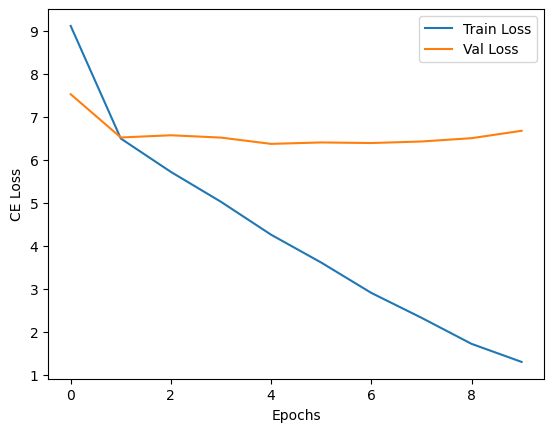

In [32]:
from matplotlib import pyplot as plt

plt.plot(range(10), trainer.history["train_loss"], label="Train Loss")
plt.plot(range(10), trainer.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.legend()

## Decoding Strategies To Control Randomness in Text Generation

### 1. Greedy Strategy

In [56]:
# Select next token always with max prob using argmax
def generate_text_sample(model, idx, max_new_tokens, context_size):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last vector
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [57]:
input_text = "how is this"
input_token_ids = tokenizer.encode(input_text)
input_token_ids = torch.tensor(input_token_ids).unsqueeze(dim=0) # add batch dimension, BATCH_SIZE, SEQ_LENGTH
output_token_ids = generate_text_sample(model, input_token_ids,
                                 max_new_tokens=25, context_size=GPT_CONFIG["context_length"])

output_token_ids = output_token_ids.squeeze(dim=0).tolist() # remove batch size
print("Output Text:", tokenizer.decode(output_token_ids))

Output Text: how is this have learned that mighty up-stream stroke.




"I turned back to my work, that one long


* Atleast, Better text generation than previously generated output with this trained model on sample data.

### 2. Temperature Scaling

* a technique that adds a probabilistic selection process to the next-token generation task.
* it is just a fancy description for dividing the logits by a number greater than 0.
* Temperature greater than 1 results in more uniformly distributed token probabilities and temperatures smaller than 1 will result in more confident distributions.

In [ ]:
def softmax_with_temperature(logits, temperature: float = 1.0):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

# Select next token always with max prob using argmax
def generate_text_sample_v2(model, idx, max_new_tokens, context_size, temperature):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last vector #logits of shape [BS, SEQ_LEGNTH, VOCAB_SIZE] => [1, 50257]
        probas = softmax_with_temperature(logits, temperature)
        idx_next = torch.multinomial(probas, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
input_text = "Every effort moves"
input_token_ids = tokenizer.encode(input_text)
input_token_ids = torch.tensor(input_token_ids).unsqueeze(dim=0) # add batch dimension, BATCH_SIZE, SEQ_LENGTH
output_token_ids = generate_text_sample_v2(model, input_token_ids,
                                 max_new_tokens=25, context_size=GPT_CONFIG["context_length"], 
                                 temperature=5)

output_token_ids = output_token_ids.squeeze(dim=0).tolist() # remove batch size
print("Output Text:", tokenizer.decode(output_token_ids))

In [55]:
input_text = "Every effort moves"
input_token_ids = tokenizer.encode(input_text)
input_token_ids = torch.tensor(input_token_ids).unsqueeze(dim=0) # add batch dimension, BATCH_SIZE, SEQ_LENGTH
output_token_ids = generate_text_sample_v2(model, input_token_ids,
                                 max_new_tokens=25, context_size=GPT_CONFIG["context_length"], 
                                 temperature=5)

output_token_ids = output_token_ids.squeeze(dim=0).tolist() # remove batch size
print("Output Text:", tokenizer.decode(output_token_ids))

Output Text: Every effort moves spuriousseeing halves bumps growersOnce mortg ensure spirits corridors Confederate distinction vacuum rode Contact searchedgovernmentRoberprep hoholesIAS Diss nodded Poo


## Top-K Sampling

* We can restrict the sampled tokens to the top-k most likely tokens and exlude all other tokens from the selection process by masking their probability scores.
* The top-k approach replaces all nonselected logits with -inf such that when computing softmax, the probability scores on the non-top-k tokens are 0,

In [64]:
def softmax_with_temperature(logits, temperature: float = 1.0, topk: int = 5):
    topk_logits, _ = torch.topk(logits, topk)
    min_val = topk_logits[:, -1]

    logits = torch.where(logits < min_val, -torch.inf, logits)
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-1)

# Select next token always with max prob using argmax
def generate_text_sample_v3(model, idx, max_new_tokens, context_size, temperature, topk:int = 10):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # last vector
        probas = softmax_with_temperature(logits, temperature, topk)
        idx_next = torch.multinomial(probas, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [65]:
input_text = "Every effort moves"
input_token_ids = tokenizer.encode(input_text)
input_token_ids = torch.tensor(input_token_ids).unsqueeze(dim=0) # add batch dimension, BATCH_SIZE, SEQ_LENGTH
output_token_ids = generate_text_sample_v3(model, input_token_ids,
                                 max_new_tokens=25, context_size=GPT_CONFIG["context_length"], 
                                 temperature=5)

output_token_ids = output_token_ids.squeeze(dim=0).tolist() # remove batch size
print("Output Text:", tokenizer.decode(output_token_ids))

Output Text: Every effort moves you in withoutace up--that was, a face the last thing he wasity"Oh--that was that it,


In [66]:
input_text = "Every effort moves"
input_token_ids = tokenizer.encode(input_text)
input_token_ids = torch.tensor(input_token_ids).unsqueeze(dim=0) # add batch dimension, BATCH_SIZE, SEQ_LENGTH
output_token_ids = generate_text_sample_v3(model, input_token_ids,
                                 max_new_tokens=25, context_size=GPT_CONFIG["context_length"], 
                                 temperature=5)

output_token_ids = output_token_ids.squeeze(dim=0).tolist() # remove batch size
print("Output Text:", tokenizer.decode(output_token_ids))

Output Text: Every effort moves his history withoutia Cro surprise pushed ax, with a _ so. forward enough him down, my work exquisitely on


### Load GPT-2 Small Pretrained Weights and Generate sample text

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [9]:
text = "Every effort moves you"
encoded_input = tokenizer(text, return_tensors='pt')
print("Encoded:", encoded_input)
print("Encoded Tensor Shape:", encoded_input["input_ids"].shape)

Encoded: {'input_ids': tensor([[6109, 3626, 6100,  345]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
Encoded Tensor Shape: torch.Size([1, 4])


In [10]:
# Greedy Strategy
output_tokens = model.generate(**encoded_input, max_new_tokens=25)
tokenizer.decode(output_tokens[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Every effort moves you forward.\n\nThe first step is to understand the importance of your work.\n\nThe second step is to understand the'

In [15]:
output_tokens = model.generate(**encoded_input, max_new_tokens=25, top_k=10, temperature=1.5, do_sample=True)
tokenizer.decode(output_tokens[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Every effort moves you towards being successful.\n\nIf it's not clear how long the effort will take (i.e., the task is"

In [16]:
output_tokens = model.generate(**encoded_input, max_new_tokens=25, top_k=10, temperature=1.5, do_sample=True)
tokenizer.decode(output_tokens[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Every effort moves you in an unexpected, sometimes surprising way. In our case it was to try and keep up with our family and friends, who'

* As you can see, a lot better output of pretrained GPT-2 model trained on larger dataset